In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pickle

# Torch
import torch
from torch.utils.data import Dataset, DataLoader

# Data

## Accelerations

In [2]:
folder_path = "HLC Results"

list_dir = os.listdir(folder_path)
list_dir = [f for f in list_dir if f.endswith('.csv')]

# Extract the numbers from the filenames
pattern = r'(\d+)'
numbers = [re.findall(pattern, filename) for filename in list_dir]
numbers = [int(num[0]) for num in numbers if num]  # Convert to integers


In [10]:
# Create a function to load all the data from the CSV files, the output should be a list
def load_data(folder_path, list_dir, numbers):
    data = []
    for i, files in enumerate(list_dir):
        # Extract the number from the filename
        file_path = os.path.join(folder_path, files)
        df = pd.read_csv(file_path, sep=',', header=0)
        data.append(df.values[:, 1:])
    return data

input_data = load_data(folder_path, list_dir, numbers)
input_data = np.array(input_data)
print("Shape of input data:", input_data.shape)

# Save array to npy file
np.savez('input_data.npz', input_data=input_data)

Shape of input data: (1000, 1500, 2)


In [11]:
loaded = np.load('input_data.npz')
loaded_data = loaded['input_data']
print(loaded_data.shape)

(1000, 1500, 2)


## Transfer functions

In [53]:
path = r'TF_HLC'

# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_1000.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_1000.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)[:, :, np.newaxis]
Vs_data = np.array(Vs_data)

# Select only one frequency
#freq_data = freq_data[300:400]
#TTF_data = TTF_data[:, 300:400]
print(TTF_data.shape, freq_data.shape)


(1000, 1000, 1) (1000,)


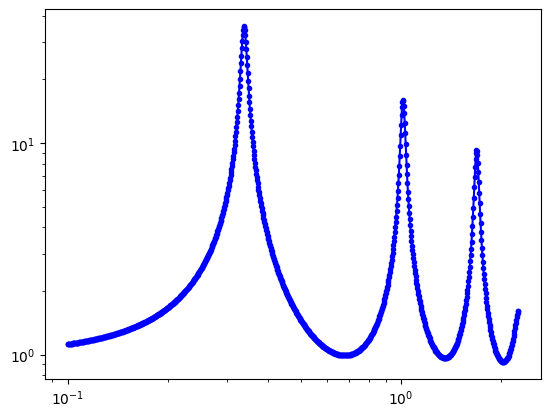

In [54]:
plt.loglog(freq_data, TTF_data[10,:], label='TTF', marker='o', markersize=3, color='blue')

## Dataset

In [55]:
class TTF_dataset(Dataset):
    def __init__(self, input_acc, TTF_data):
        self.input_acc = torch.from_numpy(input_acc).float()
        self.TTF_data = torch.from_numpy(TTF_data).float()

        # Compute the FFT of the input data
        self.fft_data = torch.fft.fft(self.input_acc, dim=1)
        self.fft_data = torch.abs(self.fft_data)[:, :int(self.fft_data.shape[1] / 2)]* 2 / self.input_acc.shape[1]

    def __len__(self):
        return len(self.input_acc)
    
    def __getitem__(self, idx):
        # Input data
        input_acc = self.fft_data[idx]

        # Output data
        TTF_data = self.TTF_data[idx]
        return input_acc, TTF_data

In [56]:
dataset = TTF_dataset(input_data, TTF_data)
print("Length of dataset:", len(dataset))
print("Shape of dataset:", dataset[0][0].shape, dataset[0][1].shape)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Lenght of train dataset:", len(train_dataset))
print("Lenght of val dataset:", len(val_dataset))

Length of dataset: 1000
Shape of dataset: torch.Size([750, 2]) torch.Size([1000, 1])
Lenght of train dataset: 800
Lenght of val dataset: 200


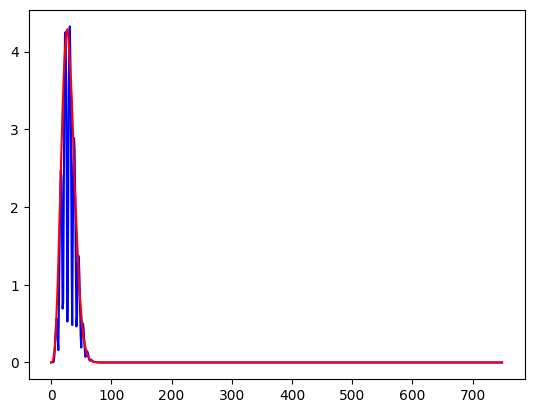

In [57]:
plt.plot(dataset[0][0][:, 0].numpy(), label='Top', color='blue')
plt.plot(dataset[0][0][:, 1].numpy(), label='Bottom', color='red')
plt.show()

In [58]:
X, y = next(iter(train_loader))
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: torch.Size([32, 750, 2])
y shape: torch.Size([32, 1000, 1])


# Model

In [59]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        attn_output, _ = self.self_attn(src, src, src, attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ffn_output = self.linear2(self.dropout(nn.ReLU()(self.linear1(src))))
        src = src + self.dropout2(ffn_output)
        src = self.norm2(src)
        return src

class TransformerModel(nn.Module):
    def __init__(self, input_seq_len, nhead, num_encoder_layers, d_model, dropout=0.1, output_seq_len=200):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.input_seq_len = input_seq_len
        self.embedding = nn.Linear(1, d_model) # Assuming input is magnitude (1 feature per bin)
        self.pos_encoder = PositionalEncoding(2 * d_model, dropout, max_len=input_seq_len)
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(2 * d_model, nhead) for _ in range(num_encoder_layers)])
        self.linear_out = nn.Linear(2 * d_model * input_seq_len, output_seq_len) # Simplistic output layer

    def forward(self, src):
        # src shape: (batch_size, num_channels=2, seq_len)
        batch_size, seq_len, seq_len = src.shape

        # Embed each feature (magnitude of each signal)
        embedded = self.embedding(src.unsqueeze(-1)).squeeze(-1) # (batch_size, seq_len, d_model)
        # embedded: (batch_size, seq_len, 2, d_model)
        B, L, C, D = embedded.shape  # Here, C is 2 and D is d_model.
        # Concatenate along the channel dimension:
        embedded = embedded.reshape(B, L, C * D)  # Now shape: (B, seq_len, 2*d_model)
        src = self.pos_encoder(embedded.permute(1, 0, 2))  # shape: (L, B, d_model)

        for enc_layer in self.encoder_layers:
            src = enc_layer(src) # (seq_len, batch_size, d_model)

        # Take the output and reshape for the final linear layer
        output = src.reshape(batch_size, -1) # (batch_size, seq_len * d_model)
        output = self.linear_out(output) # (batch_size, output_seq_len)
        return output.unsqueeze(-1) # (batch_size, 1, output_seq_len)

# Example instantiation:
input_seq_len = 750 # Number of positive frequency bins
nhead = 2 # Number of attention heads
num_encoder_layers = 2 # Number of encoder layers
d_model = 64 # Dimension of the model
dropout = 0.1
output_seq_len = 1000

model = TransformerModel(input_seq_len, nhead, num_encoder_layers, d_model, dropout, output_seq_len)

# Example input (magnitude of FFT for two signals):
batch_size = 32
fft_magnitude = torch.randn(batch_size, input_seq_len, 2)
output = model(fft_magnitude)
print(output.shape)

torch.Size([32, 1000, 1])


# Training

In [60]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, betas=(0.6, 0.98), amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Check if GPU is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [61]:
epochs = 100
train_losses = []
val_losses = []
model.to(device)
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    # Step the scheduler after each epoch
    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 60.7777, Val Loss: 25.1349
Epoch [2/100], Train Loss: 23.8666, Val Loss: 24.5928
Epoch [3/100], Train Loss: 23.9787, Val Loss: 24.8853
Epoch [4/100], Train Loss: 24.0819, Val Loss: 24.9889
Epoch [5/100], Train Loss: 23.7603, Val Loss: 24.9470
Epoch [6/100], Train Loss: 23.2830, Val Loss: 23.0600
Epoch [7/100], Train Loss: 22.5407, Val Loss: 23.0716
Epoch [8/100], Train Loss: 22.2376, Val Loss: 24.4622
Epoch [9/100], Train Loss: 22.0509, Val Loss: 23.3798
Epoch [10/100], Train Loss: 22.3032, Val Loss: 22.3076
Epoch [11/100], Train Loss: 20.7340, Val Loss: 21.7262
Epoch [12/100], Train Loss: 20.6063, Val Loss: 21.5563
Epoch [13/100], Train Loss: 20.6091, Val Loss: 21.5872
Epoch [14/100], Train Loss: 20.6405, Val Loss: 21.5712
Epoch [15/100], Train Loss: 20.6231, Val Loss: 21.5020
Epoch [16/100], Train Loss: 20.5817, Val Loss: 21.4556
Epoch [17/100], Train Loss: 20.5769, Val Loss: 21.5371
Epoch [18/100], Train Loss: 20.6064, Val Loss: 21.6232
Epoch [19/100], Tra

KeyboardInterrupt: 

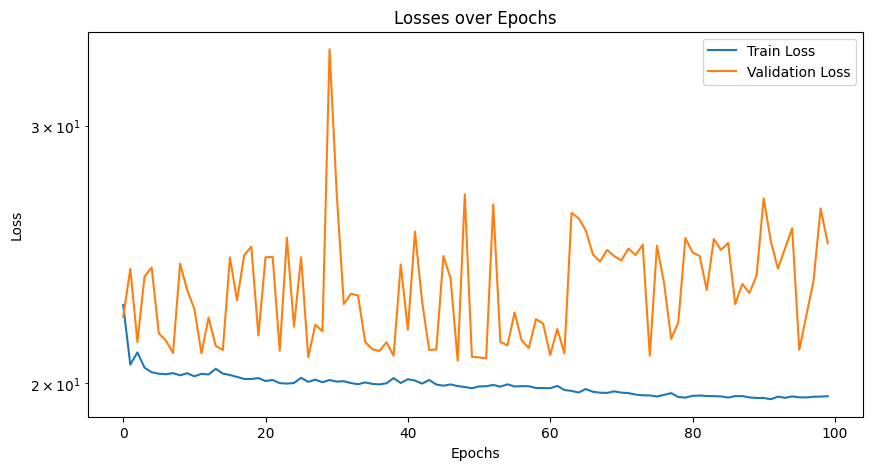

In [351]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.yscale('log')

In [352]:
# Predict on validation set
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for inputs, target in val_loader:
        inputs = inputs.to(device)
        output = model(inputs)
        predictions.append(output.cpu().numpy())
        targets.append(target.numpy())

predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

In [353]:
# Compute the pearson correlation between predictions and targets
from scipy.stats import pearsonr

# Compute the loss between predictions and targets
loss = loss_fn(torch.from_numpy(predictions), torch.from_numpy(targets))
print(f"Loss: {loss:.4f}")

# Compute the Pearson correlation coefficient
pearson_corr = []
for i in range(predictions.shape[0]):
    corr, _ = pearsonr(predictions[i].flatten(), targets[i].flatten())
    pearson_corr.append(corr)
print(f"Pearson correlation coefficient: {np.mean(pearson_corr):.4f}")
print(f"Pearson correlation coefficient std: {np.std(pearson_corr):.4f}")


Loss: 25.0986
Pearson correlation coefficient: -0.1359
Pearson correlation coefficient std: 0.1782


Text(0.5, 0, 'Pearson correlation coefficient')

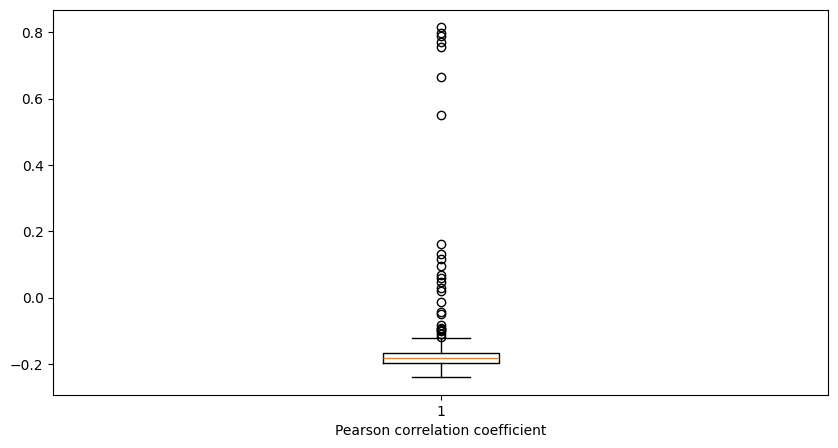

In [354]:
# Boxplot of correlation coefficients
plt.figure(figsize=(10, 5))
plt.boxplot(pearson_corr)
plt.xlabel('Pearson correlation coefficient')

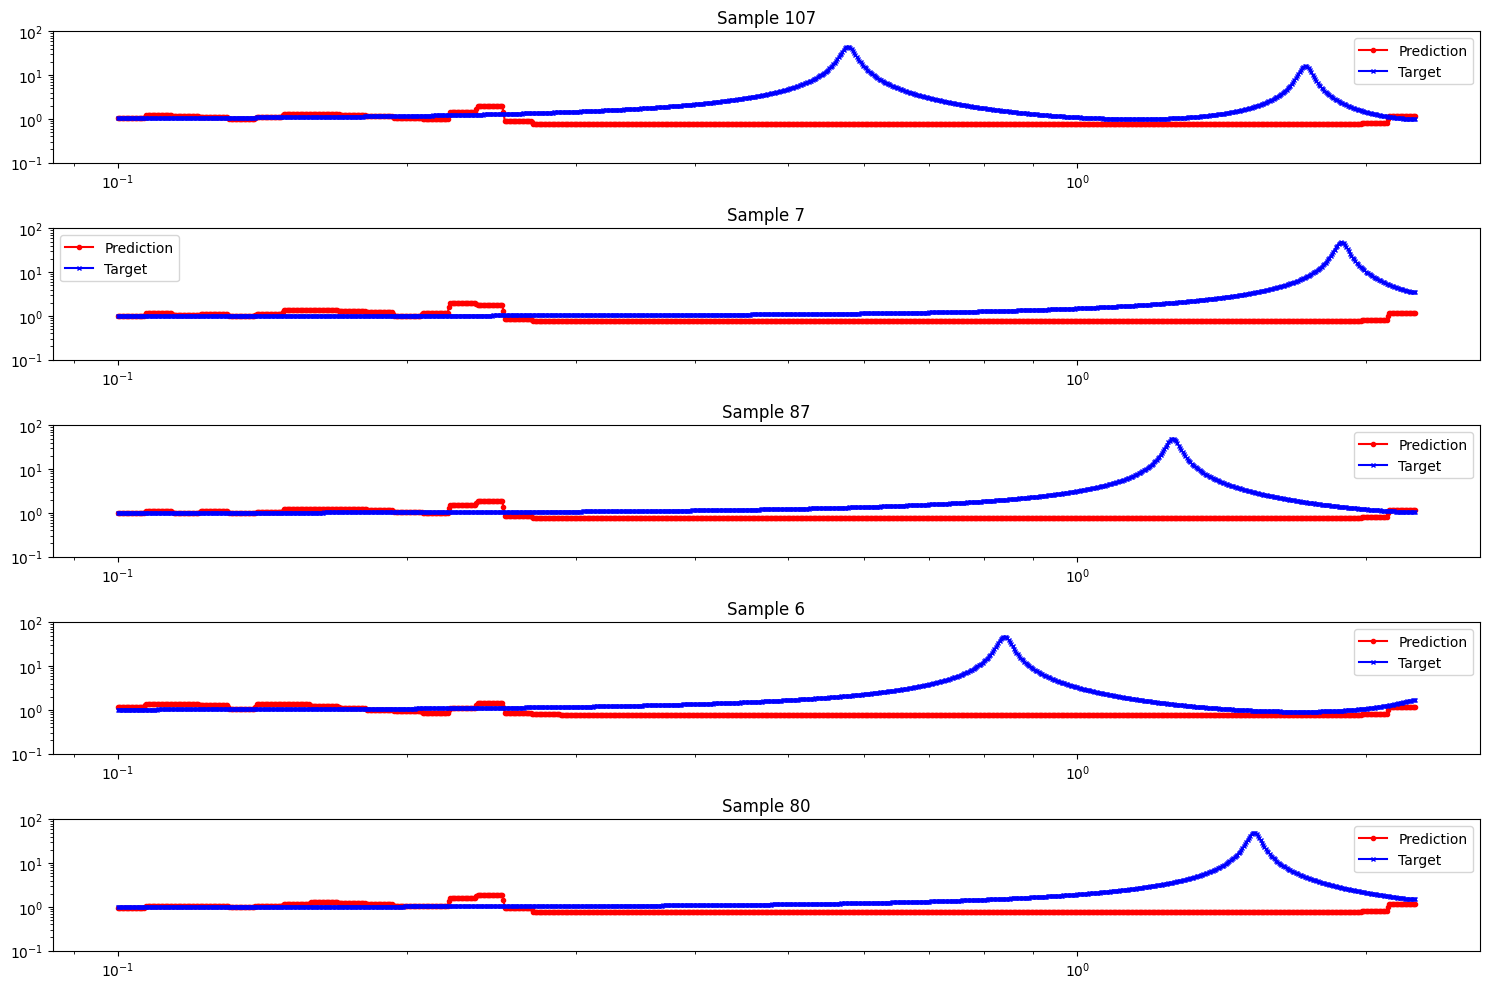

In [355]:
indx = np.random.randint(0, len(predictions), 5)
# Plot predictions vs targets for random samples
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.loglog(freq_data,predictions[indx[i]].flatten(), label='Prediction', marker='o', markersize=3, color='red')
    plt.loglog(freq_data,targets[indx[i]].flatten(), label='Target', marker='x', markersize=3, color='blue')
    plt.title(f'Sample {indx[i]}')
    plt.ylim(0.1, 1e2)
    plt.legend()
plt.tight_layout()

plt.show()